# Кластеризация и классификация парадигм
## Используемые датасеты: 
- _gsd_train_data_
- _gsd_dev_data_
- _taiga_train_data_
- _taiga_dev_data_

## Используемые методы кластеризации:
- _K-means_
- _DBSCAN_
- _Agglomerative Clustering_

### 0. Необходимые импорты

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import pandas as pd
import numpy as np
import time
import csv

### Путь к файлу с датасетом и путь сохранения нового файла

In [3]:
path_to_data = r'./data/prepared_data/GSD/gsd_train_data.csv'
path_to_save = r'./data/clustered_data/gsd_train_data_aggl__clustered.csv'

### 1. K-means

Подготовка данных:

In [4]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
data = pd.read_csv(path_to_data)    
data

,form,data
0,Начальный,"начальный,ADJ,Nom,Pos,Masc,Sing"
1,ролик,"ролик,NOUN,Inan,Nom,Masc,Sing"
2,",",",,PUNCT,None"
3,или,"или,CCONJ,None"
4,опенинг,"опенинг,NOUN,Inan,Nom,Masc,Sing"
...,...,...
11704,Израилю,"Израиль,PROPN,Inan,Dat,Masc,Sing"
11705,самые,"самый,ADJ,Inan,Acc,Pos,Plur"
11706,теплые,"теплый,ADJ,Inan,Acc,Pos,Plur"
11707,чувства,"чувство,NOUN,Inan,Acc,Neut,Plur"


In [6]:
list_kmeans = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_kmeans)))

Количество токенов в датасете: 11709


In [7]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vectorizer.fit_transform(list_kmeans).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

В зависимости от задачи и исследования можно выбрать разное количество кластеров. В нашем случае это доля от общего количества токенов в датасете:

In [8]:
n = len(list_kmeans) // 10
print('Количество кластеров: ' + str(n))

Количество кластеров: 1170


__Обучение модели K-means:__

In [9]:
%%time
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
labels = kmeans.labels_

CPU times: user 17min 26s, sys: 1min 22s, total: 18min 48s
Wall time: 4min 39s


Запись полученных результатов в необходимом формате:

In [10]:
rows = []
with open(path_to_data, encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        rows.append(row)

In [11]:
clustered_rows = []
for label in np.unique(labels):
    for word in np.array(list_kmeans)[labels == label]:
        clustered_rows.append([f'cluster_{label}', word])

In [12]:
new_rows = []
for i in clustered_rows:
    new_row = [i[0], i[1], 'data']
    for row in rows:
        if row['form'] == i[1]:
            new_row[2] = row['data']
    new_rows.append(new_row)
new_rows

[['cluster_0', 'сыграл', 'сыграть,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act'],
 ['cluster_0', 'сыграл', 'сыграть,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', '(', '(,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ':', ':,PUNCT,None'],
 ['cluster_1', 'OP', 'op,X,Yes'],
 ['cluster_1', ')', '),PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'и', 'и,CCONJ,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'в', 'в,ADP,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_1', 'и', 'и,CCONJ,None'],
 ['cluster_1', 'и', 'и,CCONJ,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['clu

In [13]:
new_df = pd.DataFrame(columns=['cluster', 'form', 'data'])
m = 0
for i in new_rows:
    new_df.loc[m] = i
    m+=1

In [14]:
new_df.to_csv(path_to_save, index=False)

### 2. DBSCAN

Подготовка данных:

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
data = pd.read_csv(path_to_data)
data

,form,data
0,Начальный,"начальный,ADJ,Nom,Pos,Masc,Sing"
1,ролик,"ролик,NOUN,Inan,Nom,Masc,Sing"
2,",",",,PUNCT,None"
3,или,"или,CCONJ,None"
4,опенинг,"опенинг,NOUN,Inan,Nom,Masc,Sing"
...,...,...
11704,Израилю,"Израиль,PROPN,Inan,Dat,Masc,Sing"
11705,самые,"самый,ADJ,Inan,Acc,Pos,Plur"
11706,теплые,"теплый,ADJ,Inan,Acc,Pos,Plur"
11707,чувства,"чувство,NOUN,Inan,Acc,Neut,Plur"


In [17]:
list_dbscan = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_dbscan)))

Количество токенов в датасете: 11709


In [18]:
vectorizer = TfidfVectorizer()
word_vectors = vectorizer.fit_transform(list_dbscan)

In [19]:
vectorizer2 = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vectorizer2.fit_transform(list_dbscan).toarray()

__Обучение модели DBSCAN:__

In [20]:
%%time
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(X)

CPU times: user 17.7 s, sys: 3.91 s, total: 21.6 s
Wall time: 6.96 s


Запись полученных результатов в необходимом формате:

In [21]:
rows = []
with open(path_to_data, encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        rows.append(row)

In [22]:
clustered_rows = []
for word, cluster in zip(list_dbscan, clusters):
    clustered_rows.append([f'cluster_{cluster}', word])

In [23]:
new_rows = []
for i in clustered_rows:
    new_row = [i[0], i[1], 'data']
    for row in rows:
        if row['form'] == i[1]:
            new_row[2] = row['data']
    new_rows.append(new_row)
new_rows

[['cluster_-1', 'Начальный', 'начальный,ADJ,Nom,Pos,Masc,Sing'],
 ['cluster_-1', 'ролик', 'ролик,NOUN,Inan,Nom,Masc,Sing'],
 ['cluster_0', ',', ',,PUNCT,None'],
 ['cluster_1', 'или', 'или,CCONJ,None'],
 ['cluster_-1', 'опенинг', 'опенинг,NOUN,Inan,Nom,Masc,Sing'],
 ['cluster_0', '(', '(,PUNCT,None'],
 ['cluster_2', 'от', 'от,ADP,None'],
 ['cluster_0', ',', ',,PUNCT,None'],
 ['cluster_-1', 'сокр.', 'сокращенно,ADV,Pos'],
 ['cluster_0', ':', ':,PUNCT,None'],
 ['cluster_-1', 'OP', 'op,X,Yes'],
 ['cluster_0', ')', '),PUNCT,None'],
 ['cluster_0', ',', ',,PUNCT,None'],
 ['cluster_3', 'как', 'как,ADV,None'],
 ['cluster_-1', 'правило', 'правило,NOUN,Inan,Nom,Neut,Sing'],
 ['cluster_0', ',', ',,PUNCT,None'],
 ['cluster_-1',
  'представляет',
  'представлять,VERB,Imp,Ind,Sing,3,Pres,Fin,Act'],
 ['cluster_4', 'собой', 'себя,PRON,Ins,Yes'],
 ['cluster_-1', 'анимацию', 'анимация,NOUN,Inan,Acc,Fem,Sing'],
 ['cluster_0', ',', ',,PUNCT,None'],
 ['cluster_-1',
  'изображающую',
  'изображать,VERB,Inan,

In [24]:
new_df = pd.DataFrame(columns=['cluster', 'form', 'data'])
m = 0
for i in new_rows:
    new_df.loc[m] = i
    m+=1

In [25]:
new_df.to_csv(path_to_save, index=False)

### 3. Agglomerative clustering

Подготовка данных:

In [26]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
data = pd.read_csv(path_to_data)
data

,form,data
0,Начальный,"начальный,ADJ,Nom,Pos,Masc,Sing"
1,ролик,"ролик,NOUN,Inan,Nom,Masc,Sing"
2,",",",,PUNCT,None"
3,или,"или,CCONJ,None"
4,опенинг,"опенинг,NOUN,Inan,Nom,Masc,Sing"
...,...,...
11704,Израилю,"Израиль,PROPN,Inan,Dat,Masc,Sing"
11705,самые,"самый,ADJ,Inan,Acc,Pos,Plur"
11706,теплые,"теплый,ADJ,Inan,Acc,Pos,Plur"
11707,чувства,"чувство,NOUN,Inan,Acc,Neut,Plur"


In [28]:
list_aggl = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_aggl)))

Количество токенов в датасете: 11709


In [29]:
vectorizer = TfidfVectorizer()
word_vectors = vectorizer.fit_transform(list_aggl)

In [30]:
vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vectorizer3.fit_transform(list_aggl).toarray()

__Обучение модели Agglomerative Clustering:__

In [31]:
%%time
clustering = AgglomerativeClustering(n_clusters=7000)
clusters = clustering.fit_predict(X)

CPU times: user 2min, sys: 3.11 s, total: 2min 3s
Wall time: 2min 5s


Запись полученных результатов в необходимом формате:

In [32]:
%%time
rows = []
with open(path_to_data, encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        rows.append(row)

CPU times: user 46.4 ms, sys: 4.17 ms, total: 50.6 ms
Wall time: 49.5 ms


In [33]:
clustered_rows = []
for word, cluster in zip(list_aggl, clusters):
    clustered_rows.append([f'cluster_{cluster}', word])

In [34]:
%%time
new_rows = []
for i in clustered_rows:
    new_row = [i[0], i[1], 'data']
    for row in rows:
        if row['form'] == i[1]:
            new_row[2] = row['data']
    new_rows.append(new_row)
new_rows

CPU times: user 24.4 s, sys: 175 ms, total: 24.5 s
Wall time: 24.7 s


[['cluster_4211', 'Начальный', 'начальный,ADJ,Nom,Pos,Masc,Sing'],
 ['cluster_5388', 'ролик', 'ролик,NOUN,Inan,Nom,Masc,Sing'],
 ['cluster_215', ',', ',,PUNCT,None'],
 ['cluster_132', 'или', 'или,CCONJ,None'],
 ['cluster_4210', 'опенинг', 'опенинг,NOUN,Inan,Nom,Masc,Sing'],
 ['cluster_215', '(', '(,PUNCT,None'],
 ['cluster_257', 'от', 'от,ADP,None'],
 ['cluster_215', ',', ',,PUNCT,None'],
 ['cluster_3568', 'сокр.', 'сокращенно,ADV,Pos'],
 ['cluster_215', ':', ':,PUNCT,None'],
 ['cluster_5230', 'OP', 'op,X,Yes'],
 ['cluster_215', ')', '),PUNCT,None'],
 ['cluster_215', ',', ',,PUNCT,None'],
 ['cluster_143', 'как', 'как,ADV,None'],
 ['cluster_3839', 'правило', 'правило,NOUN,Inan,Nom,Neut,Sing'],
 ['cluster_215', ',', ',,PUNCT,None'],
 ['cluster_445',
  'представляет',
  'представлять,VERB,Imp,Ind,Sing,3,Pres,Fin,Act'],
 ['cluster_781', 'собой', 'себя,PRON,Ins,Yes'],
 ['cluster_5188', 'анимацию', 'анимация,NOUN,Inan,Acc,Fem,Sing'],
 ['cluster_215', ',', ',,PUNCT,None'],
 ['cluster_6819',
 

In [35]:
new_df = pd.DataFrame(columns=['cluster', 'form', 'data'])
m = 0
for i in new_rows:
    new_df.loc[m] = i
    m+=1

In [36]:
new_df.to_csv(path_to_save, index=False)

## Elbow method

In [37]:
from sklearn.cluster import AgglomerativeClustering
import sklearn
import matplotlib.pyplot as plt

Выбираем входные данные:

In [39]:
data_elbow = pd.read_csv(r'/Users/mefeoss/Documents/DIPLOM/for_clust/gsd_dev_data.csv')
words_elbow = data_elbow['form'].to_list()
print(len(words_elbow))

11709


Преобразование слов в числовые векторы:

In [40]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
word_vectors = vectorizer.fit_transform(words_elbow).toarray()

Выбираем разное количество кластеров и создаем список инерции для каждого количества кластеров:

In [41]:
%%time
num_clusters = range(1, 50, 10)

inertias = []
for k in num_clusters:
    clustering = KMeans(n_clusters=k, random_state=0)
    clustering.fit(word_vectors)
    inertias.append(clustering.inertia_)

CPU times: user 2min 47s, sys: 15.9 s, total: 3min 3s
Wall time: 33.5 s


Визуализируем изменения инерции:

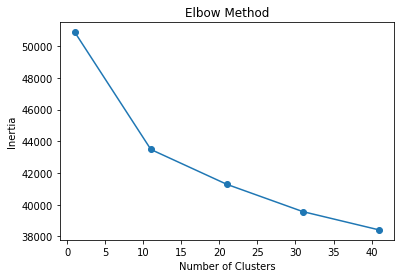

In [42]:
plt.plot(num_clusters, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [43]:
plt.savefig(r'/Users/mefeoss/Documents/DIPLOM/for_clust/elbow_1_50_kmeans_gsd_dev.png')

<Figure size 432x288 with 0 Axes>